###### **Project:** NORI  
**Author:** Yuseof J  
**Date:** 28/12/25

### **Purpose**


### **Inputs**
- ``

### **Outputs**
- ``
  
--------------------------------------------------------------------------

### 0. Imports and Setup

In [8]:
# package imports
import os
import shap
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# specify filepaths
path_nyc_tracts = 'data/processed/nyc_tracts.gpkg'
path_model_features = 'data/processed/master_features.csv'
path_model_targets = 'data/processed/outcomes_econ_mobility.csv'
path_performance_metrics = 'data/processed/model_performance_econ_mobility.csv'
path_final_model_pkl = 'models/xgb_econ_mobility_model.pkl'
path_output_tract_preds = 'data/processed/predictions_econ_mobility.csv'
output_gpkg_layer = 'econ_mobility_predictions'

# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

### 1. Load Data

In [9]:
# load economic mobility model
with open(path_final_model_pkl, 'rb') as model_file:
    model = pickle.load(model_file)

# load tracts with features 
X = pd.read_csv(path_model_features)

In [ ]:
2. 

In [11]:
# drop nan rows in feature set before running shap 
X = X.dropna()

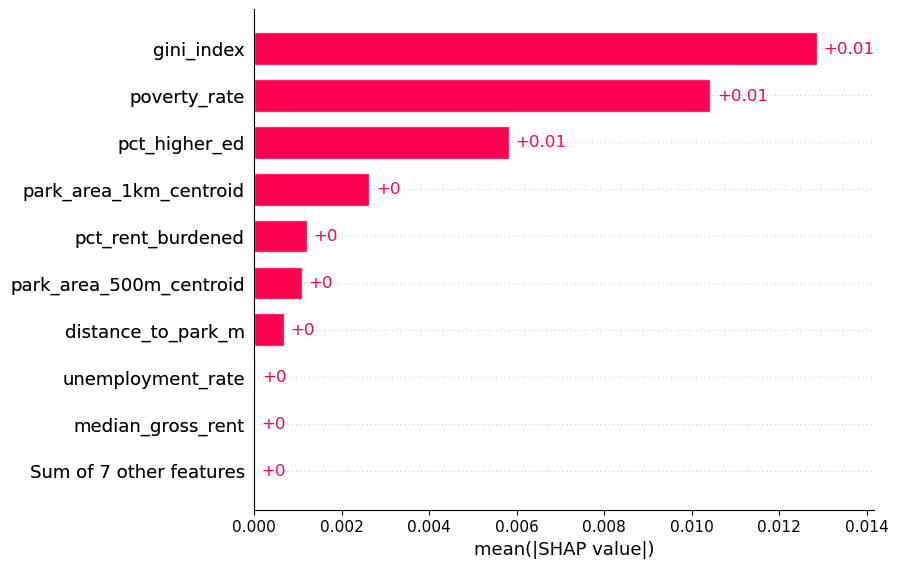

In [13]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)